In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
rcParams.update({'legend.fontsize': '18',
                 'axes.labelsize': '18',
                 'axes.titlesize': '18',
                 'xtick.labelsize': '18',
                 'ytick.labelsize': '18'})

# P6 - Distance and Velocity Estimation

R2D2, the successor of the out-dated cleaning robot C3PO, is able to measure it's position in space
$\begin{bmatrix}\alpha_x(n) &\alpha_y(n)\end{bmatrix}^T$ by querying his build in sensors. The measurements $\mathbf{z}(n)$ are
corrupted by zero-mean white Gaussian noise $\mathbf{v}_2(n)$ of covariance matrix $\mathbf{Q}_2$.
Starting with the assumption of a continuous movement in space with approximately constant velocity
$\begin{bmatrix}\alpha_{v_x}(n) &\alpha_{v_y}(n)\end{bmatrix}^T$, the true position and velocity should be estimated based on
the measured position. Since R2D2 is able to maneuver, his velocity differs from the assumed
constant one. This is taken into account by introducing the zero-mean white Gaussian system noise
$\mathbf{v}_1(n)$ of covariance matrix $\mathbf{Q_1}$. The movements and measurements underlie the
following behavior:

\begin{eqnarray*}
\begin{bmatrix}\alpha_x(n+1) \\ \alpha_y(n+1) \\ \alpha_{v_x}(n+1) \\ \alpha_{v_y}(n+1) \end{bmatrix} &=& \begin{bmatrix} 1 & 0 & T & 0\\ 0 & 1 & 0 & T\\ 0 & 0 & 1 & 0\\0 & 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} \alpha_x(n) \\ \alpha_y(n) \\ \alpha_{v_x}(n) \\ \alpha_{v_y}(n) \end{bmatrix} + \mathbf{v}_1(n)\\
\mathbf{z}(n) &=& \begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \end{bmatrix} \begin{bmatrix} \alpha_x(n) \\ \alpha_y(n) \\ \alpha_{v_x}(n) \\ \alpha_{v_y}(n) \end{bmatrix} + \mathbf{v}_2(n)
\end{eqnarray*}
whereas
\begin{eqnarray*}
\mathbf{Q}_1 &=& \begin{bmatrix}
a_x  \frac{T^4}{4}& 0& a_x \frac{T^3}{2} & 0\\
0& a_y \frac{T^4}{4} & 0 & a_y \frac{T^3}{2}\\
a_x \frac{T^3}{2} & 0 & a_x T & 0\\
0 & a_y \frac{T^3}{2} & 0 & a_y T
\end{bmatrix} \text{ and}\\
\mathbf{Q}_2 &=& \begin{bmatrix} \sigma_x^2 & 0 \\ 0 & \sigma_y^2 \end{bmatrix},
\end{eqnarray*}
with $a_x$ and $a_y$ being given constants (accelaration terms).

### System Description:

In [3]:
# sampling period in seconds
T = 0.1

# total simulation time in seconds
total_time = 30

# System matrix
F = np.eye(4)
F[0,2] = T
F[1,3] = T
F

array([[1. , 0. , 0.1, 0. ],
       [0. , 1. , 0. , 0.1],
       [0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. ]])

In [4]:
# Measurement matrix
H = np.concatenate((np.eye(2), np.zeros((2,2))), 1).T
H

array([[1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.]])

In [5]:
# influence of the noise on the system state
#How the noise is assigned to states, i.e. no correlated noise between states.
G = np.eye(4)
G

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [6]:
# covariance matrix of the measurement noise
#Noise is uncorrelated to measurements, i.e. no correlated noise between measurements.
sigma_x = 1
sigma_y = 1
Q_2 = np.diag([sigma_x**2, sigma_y**2])
Q_2

array([[1, 0],
       [0, 1]])

In [7]:
# covariance matrix of the system noise
a_x = 1
a_y = 1
Q_1 = np.asarray([[a_x * T ** 4 / 4, 0, a_x * T ** 3 / 2, 0],
                 [0, a_y * T ** 4 / 4, 0, a_y * T ** 3 / 2],
                 [a_x * T ** 3 / 2, 0 , a_x * T, 0],
                 [0, a_y * T ** 3 / 2, 0, a_y * T]])
Q_1

array([[2.5e-05, 0.0e+00, 5.0e-04, 0.0e+00],
       [0.0e+00, 2.5e-05, 0.0e+00, 5.0e-04],
       [5.0e-04, 0.0e+00, 1.0e-01, 0.0e+00],
       [0.0e+00, 5.0e-04, 0.0e+00, 1.0e-01]])

### State tracking:

a) Evaluate the system equations each $T=0.1s$ to generate a series of ''true'' state vectors
representing $30s$ of movement in R2D2's life. Choose an appropriate initialization and use
$a_x=a_y=\sigma_x^2=\sigma_y^2=1$.

b) Generate the noisy measurements for R2D2's position.

c) Implement the Kalman-Filter to estimate R2D2's position and velocity, solely
based on the noisy observations of his position. Display the estimated state variables
together with the underlying true ones.

In [8]:
# Initialization with a priori knowledge:

# Random start position according to known statistics
true_state = np.random.multivariate_normal(np.zeros(4), Q_1).T
true_state

array([ 0.00075943,  0.00274014, -0.12037411, -0.08753269])

In [9]:
# Initialization of state estimate, i.e. alpha_hat(1|0)
#eq. 7.32
state_prediction = np.zeros((4,1))
state_prediction

array([[0.],
       [0.],
       [0.],
       [0.]])

In [10]:
# Initial covariance matrix of estimation error, i.e. Sigma(1|0)
#eq. 7.33
C_0 = Q_1
S = F @ C_0 @ F.T + G @ Q_1 @ G.T

In [11]:
total_steps = np.arange(0, total_time, T)
true_position_history = np.zeros((len(total_steps), 2))
position_estimate_history = np.zeros((len(total_steps), 2))
observation_history = np.zeros((len(total_steps), 2))

In [12]:
print('total_steps: ', total_steps.shape)
print('true_position_history: ', true_position_history.shape)
print('position_estimate_history: ', position_estimate_history.shape) 
print('observation_history: ', observation_history.shape)

total_steps:  (300,)
true_position_history:  (300, 2)
position_estimate_history:  (300, 2)
observation_history:  (300, 2)


In [13]:
v1 = np.random.multivariate_normal(np.zeros(4), Q_1, 1).T
print('system state noise v1: ', v1)
v2 = np.random.multivariate_normal(np.zeros(2), Q_2, 1).T
print('masurement noise v2: ', v2)

system state noise v1:  [[ 0.00150405]
 [ 0.01050705]
 [ 0.41910518]
 [-0.00420286]]
masurement noise v2:  [[-0.09942837]
 [-0.14506635]]


In [14]:
#Kalman filter algorithm
for counter, t in enumerate(total_steps):
    # Calculate next true system state # system eq. 7.1
    v1 = np.random.multivariate_normal(np.zeros(4), Q_1, 1).T     # .T stands for transpose
    true_state = F @ true_state + G @ v1 
    
    # Calculate current observation # measurement eq. 7.5
    v2 = np.random.multivariate_normal(np.zeros(2), Q_2, 1).T
    z = H.T @ true_state + v2
    
    # Kalman gain #eq. 7.35
    K = S @ H @ np.linalg.inv(H.T @ S @ H + Q_2)
    
    # Innovation sequence #eq. 7.36
    innovation = z - H.T @ state_prediction
    
    # Current state estimate #alpha_hat(n|n) #eq. 7.37
    state_estimate = state_prediction + K @ innovation
    
    # One step recursion for state prediction #alpha_hat(n+1|n) #eq. 7.38
    state_prediction = F @ state_estimate
    
    # one step recursion for state prediction covariance matrix #7.40
    S = F @ S @ F.T - F @ K @ H.T @ S @ F.T + G @ Q_1 @ G.T
    
    # Save history
    true_position_history[counter, :] = true_state[:2, 0]
    observation_history[counter, :] = z[:, 0]
    position_estimate_history[counter, :] = state_estimate[:2, 0]
    
    print("counter:------------> ", counter+1)
    print("true_position_history: ", true_position_history)
    print("observation_history: ", observation_history)    
    print("position_estimate_history: ", position_estimate_history)    

counter:------------>  1
true_position_history:  [[-0.00346561 -0.0166972 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0. 

position_estimate_history:  [[-0.00303877  0.00086784]
 [-0.0146168  -0.00255534]
 [-0.02630884 -0.01245974]
 [-0.04196593 -0.03776971]
 [-0.11253538 -0.04427519]
 [-0.20910212 -0.09593363]
 [-0.19224702 -0.13878223]
 [-0.10946376  0.10595824]
 [-0.0399497   0.30195603]
 [ 0.14500457  0.71771558]
 [ 0.08677775  0.80784648]
 [ 0.02511305  0.71031155]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]


counter:------------>  14
true_position_history:  [[-0.00346561 -0.0166972 ]
 [-0.05095418  0.02035047]
 [-0.08641978  0.05913967]
 [-0.09531929  0.13098404]
 [-0.07575306  0.23880149]
 [-0.0494777   0.33555464]
 [ 0.01164479  0.40210836]
 [ 0.08182824  0.472691  ]
 [ 0.1913274   0.56180771]
 [ 0.29573459  0.66663208]
 [ 0.44112833  0.72362109]
 [ 0.6029533   0.77983242]
 [ 0.77505769  0.797687  ]
 [ 0.96373275  0.79686387]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.

position_estimate_history:  [[-3.03876723e-03  8.67836006e-04]
 [-1.46168042e-02 -2.55534093e-03]
 [-2.63088364e-02 -1.24597417e-02]
 [-4.19659275e-02 -3.77697098e-02]
 [-1.12535376e-01 -4.42751863e-02]
 [-2.09102125e-01 -9.59336279e-02]
 [-1.92247024e-01 -1.38782229e-01]
 [-1.09463762e-01  1.05958237e-01]
 [-3.99496961e-02  3.01956032e-01]
 [ 1.45004568e-01  7.17715582e-01]
 [ 8.67777499e-02  8.07846480e-01]
 [ 2.51130525e-02  7.10311548e-01]
 [ 8.62510035e-02  6.92768250e-01]
 [ 4.05516361e-01  2.62579766e-01]
 [ 5.89542669e-01  3.22237755e-01]
 [ 7.63069088e-01  5.46270662e-01]
 [ 1.21208191e+00  8.14375429e-01]
 [ 1.40966567e+00  5.36961775e-01]
 [ 1.87011673e+00  2.78023337e-01]
 [ 1.78956364e+00  2.76952176e-01]
 [ 2.21545668e+00  2.20360274e-01]
 [ 2.97266148e+00  2.14783301e-01]
 [ 3.31191043e+00 -1.23913083e-01]
 [ 3.64484622e+00 -4.50169572e-01]
 [ 3.61372224e+00 -7.78855184e-01]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.000000

counter:------------>  30
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3.

counter:------------>  40
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3.

counter:------------>  43
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3.

counter:------------>  44
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3.

counter:------------>  53
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3.

position_estimate_history:  [[-3.03876723e-03  8.67836006e-04]
 [-1.46168042e-02 -2.55534093e-03]
 [-2.63088364e-02 -1.24597417e-02]
 [-4.19659275e-02 -3.77697098e-02]
 [-1.12535376e-01 -4.42751863e-02]
 [-2.09102125e-01 -9.59336279e-02]
 [-1.92247024e-01 -1.38782229e-01]
 [-1.09463762e-01  1.05958237e-01]
 [-3.99496961e-02  3.01956032e-01]
 [ 1.45004568e-01  7.17715582e-01]
 [ 8.67777499e-02  8.07846480e-01]
 [ 2.51130525e-02  7.10311548e-01]
 [ 8.62510035e-02  6.92768250e-01]
 [ 4.05516361e-01  2.62579766e-01]
 [ 5.89542669e-01  3.22237755e-01]
 [ 7.63069088e-01  5.46270662e-01]
 [ 1.21208191e+00  8.14375429e-01]
 [ 1.40966567e+00  5.36961775e-01]
 [ 1.87011673e+00  2.78023337e-01]
 [ 1.78956364e+00  2.76952176e-01]
 [ 2.21545668e+00  2.20360274e-01]
 [ 2.97266148e+00  2.14783301e-01]
 [ 3.31191043e+00 -1.23913083e-01]
 [ 3.64484622e+00 -4.50169572e-01]
 [ 3.61372224e+00 -7.78855184e-01]
 [ 4.09083373e+00 -6.58898223e-01]
 [ 4.46276496e+00 -1.02990632e+00]
 [ 4.90264299e+00 -9.654263

counter:------------>  56
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3.

observation_history:  [[-2.64544505  0.75550784]
 [-1.62941785 -0.79460857]
 [-0.27963356 -0.57630345]
 [-0.24183763 -0.69807362]
 [-1.20348462  0.05360096]
 [-1.02206822 -0.58265723]
 [ 0.30811437 -0.32874556]
 [ 0.6121938   1.80916273]
 [ 0.37545933  1.19209693]
 [ 0.96536019  2.35143272]
 [-0.27530314  0.73517584]
 [-0.27977502 -0.06938248]
 [ 0.28720763  0.34022171]
 [ 1.51210589 -1.53304294]
 [ 1.05932425  0.52960965]
 [ 1.13446133  1.3134367 ]
 [ 2.51858134  1.6423195 ]
 [ 1.65893184 -0.68091934]
 [ 3.02518366 -0.72409486]
 [ 0.87530253  0.31691067]
 [ 3.21683206  0.05779239]
 [ 5.02631193  0.25380805]
 [ 3.62496047 -1.27149471]
 [ 3.89605581 -1.40894781]
 [ 2.54692586 -1.62492711]
 [ 4.95116628  0.184078  ]
 [ 4.84390605 -2.02161264]
 [ 5.47423503 -0.30144072]
 [ 2.83421642 -1.96590011]
 [ 2.92107508 -2.70743393]
 [ 3.32292119 -0.71394641]
 [ 3.60501968 -4.47430262]
 [ 5.14543247 -2.81079711]
 [ 2.66323576 -1.99284967]
 [ 4.19724203 -2.29872101]
 [ 3.79476709 -0.58279551]
 [ 3.5

counter:------------>  65
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3.

counter:------------>  67
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3.

observation_history:  [[-2.64544505  0.75550784]
 [-1.62941785 -0.79460857]
 [-0.27963356 -0.57630345]
 [-0.24183763 -0.69807362]
 [-1.20348462  0.05360096]
 [-1.02206822 -0.58265723]
 [ 0.30811437 -0.32874556]
 [ 0.6121938   1.80916273]
 [ 0.37545933  1.19209693]
 [ 0.96536019  2.35143272]
 [-0.27530314  0.73517584]
 [-0.27977502 -0.06938248]
 [ 0.28720763  0.34022171]
 [ 1.51210589 -1.53304294]
 [ 1.05932425  0.52960965]
 [ 1.13446133  1.3134367 ]
 [ 2.51858134  1.6423195 ]
 [ 1.65893184 -0.68091934]
 [ 3.02518366 -0.72409486]
 [ 0.87530253  0.31691067]
 [ 3.21683206  0.05779239]
 [ 5.02631193  0.25380805]
 [ 3.62496047 -1.27149471]
 [ 3.89605581 -1.40894781]
 [ 2.54692586 -1.62492711]
 [ 4.95116628  0.184078  ]
 [ 4.84390605 -2.02161264]
 [ 5.47423503 -0.30144072]
 [ 2.83421642 -1.96590011]
 [ 2.92107508 -2.70743393]
 [ 3.32292119 -0.71394641]
 [ 3.60501968 -4.47430262]
 [ 5.14543247 -2.81079711]
 [ 2.66323576 -1.99284967]
 [ 4.19724203 -2.29872101]
 [ 3.79476709 -0.58279551]
 [ 3.5

counter:------------>  78
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3.

counter:------------>  79
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3.

position_estimate_history:  [[-3.03876723e-03  8.67836006e-04]
 [-1.46168042e-02 -2.55534093e-03]
 [-2.63088364e-02 -1.24597417e-02]
 [-4.19659275e-02 -3.77697098e-02]
 [-1.12535376e-01 -4.42751863e-02]
 [-2.09102125e-01 -9.59336279e-02]
 [-1.92247024e-01 -1.38782229e-01]
 [-1.09463762e-01  1.05958237e-01]
 [-3.99496961e-02  3.01956032e-01]
 [ 1.45004568e-01  7.17715582e-01]
 [ 8.67777499e-02  8.07846480e-01]
 [ 2.51130525e-02  7.10311548e-01]
 [ 8.62510035e-02  6.92768250e-01]
 [ 4.05516361e-01  2.62579766e-01]
 [ 5.89542669e-01  3.22237755e-01]
 [ 7.63069088e-01  5.46270662e-01]
 [ 1.21208191e+00  8.14375429e-01]
 [ 1.40966567e+00  5.36961775e-01]
 [ 1.87011673e+00  2.78023337e-01]
 [ 1.78956364e+00  2.76952176e-01]
 [ 2.21545668e+00  2.20360274e-01]
 [ 2.97266148e+00  2.14783301e-01]
 [ 3.31191043e+00 -1.23913083e-01]
 [ 3.64484622e+00 -4.50169572e-01]
 [ 3.61372224e+00 -7.78855184e-01]
 [ 4.09083373e+00 -6.58898223e-01]
 [ 4.46276496e+00 -1.02990632e+00]
 [ 4.90264299e+00 -9.654263

counter:------------>  93
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3.

observation_history:  [[-2.64544505  0.75550784]
 [-1.62941785 -0.79460857]
 [-0.27963356 -0.57630345]
 [-0.24183763 -0.69807362]
 [-1.20348462  0.05360096]
 [-1.02206822 -0.58265723]
 [ 0.30811437 -0.32874556]
 [ 0.6121938   1.80916273]
 [ 0.37545933  1.19209693]
 [ 0.96536019  2.35143272]
 [-0.27530314  0.73517584]
 [-0.27977502 -0.06938248]
 [ 0.28720763  0.34022171]
 [ 1.51210589 -1.53304294]
 [ 1.05932425  0.52960965]
 [ 1.13446133  1.3134367 ]
 [ 2.51858134  1.6423195 ]
 [ 1.65893184 -0.68091934]
 [ 3.02518366 -0.72409486]
 [ 0.87530253  0.31691067]
 [ 3.21683206  0.05779239]
 [ 5.02631193  0.25380805]
 [ 3.62496047 -1.27149471]
 [ 3.89605581 -1.40894781]
 [ 2.54692586 -1.62492711]
 [ 4.95116628  0.184078  ]
 [ 4.84390605 -2.02161264]
 [ 5.47423503 -0.30144072]
 [ 2.83421642 -1.96590011]
 [ 2.92107508 -2.70743393]
 [ 3.32292119 -0.71394641]
 [ 3.60501968 -4.47430262]
 [ 5.14543247 -2.81079711]
 [ 2.66323576 -1.99284967]
 [ 4.19724203 -2.29872101]
 [ 3.79476709 -0.58279551]
 [ 3.5

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



counter:------------>  213
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3

counter:------------>  217
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3

counter:------------>  231
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3

counter:------------>  232
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3

position_estimate_history:  [[-3.03876723e-03  8.67836006e-04]
 [-1.46168042e-02 -2.55534093e-03]
 [-2.63088364e-02 -1.24597417e-02]
 [-4.19659275e-02 -3.77697098e-02]
 [-1.12535376e-01 -4.42751863e-02]
 [-2.09102125e-01 -9.59336279e-02]
 [-1.92247024e-01 -1.38782229e-01]
 [-1.09463762e-01  1.05958237e-01]
 [-3.99496961e-02  3.01956032e-01]
 [ 1.45004568e-01  7.17715582e-01]
 [ 8.67777499e-02  8.07846480e-01]
 [ 2.51130525e-02  7.10311548e-01]
 [ 8.62510035e-02  6.92768250e-01]
 [ 4.05516361e-01  2.62579766e-01]
 [ 5.89542669e-01  3.22237755e-01]
 [ 7.63069088e-01  5.46270662e-01]
 [ 1.21208191e+00  8.14375429e-01]
 [ 1.40966567e+00  5.36961775e-01]
 [ 1.87011673e+00  2.78023337e-01]
 [ 1.78956364e+00  2.76952176e-01]
 [ 2.21545668e+00  2.20360274e-01]
 [ 2.97266148e+00  2.14783301e-01]
 [ 3.31191043e+00 -1.23913083e-01]
 [ 3.64484622e+00 -4.50169572e-01]
 [ 3.61372224e+00 -7.78855184e-01]
 [ 4.09083373e+00 -6.58898223e-01]
 [ 4.46276496e+00 -1.02990632e+00]
 [ 4.90264299e+00 -9.654263

counter:------------>  247
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3

observation_history:  [[-2.64544505e+00  7.55507841e-01]
 [-1.62941785e+00 -7.94608570e-01]
 [-2.79633565e-01 -5.76303449e-01]
 [-2.41837627e-01 -6.98073620e-01]
 [-1.20348462e+00  5.36009553e-02]
 [-1.02206822e+00 -5.82657230e-01]
 [ 3.08114370e-01 -3.28745561e-01]
 [ 6.12193800e-01  1.80916273e+00]
 [ 3.75459331e-01  1.19209693e+00]
 [ 9.65360189e-01  2.35143272e+00]
 [-2.75303135e-01  7.35175838e-01]
 [-2.79775020e-01 -6.93824818e-02]
 [ 2.87207633e-01  3.40221710e-01]
 [ 1.51210589e+00 -1.53304294e+00]
 [ 1.05932425e+00  5.29609647e-01]
 [ 1.13446133e+00  1.31343670e+00]
 [ 2.51858134e+00  1.64231950e+00]
 [ 1.65893184e+00 -6.80919342e-01]
 [ 3.02518366e+00 -7.24094859e-01]
 [ 8.75302526e-01  3.16910673e-01]
 [ 3.21683206e+00  5.77923905e-02]
 [ 5.02631193e+00  2.53808054e-01]
 [ 3.62496047e+00 -1.27149471e+00]
 [ 3.89605581e+00 -1.40894781e+00]
 [ 2.54692586e+00 -1.62492711e+00]
 [ 4.95116628e+00  1.84078000e-01]
 [ 4.84390605e+00 -2.02161264e+00]
 [ 5.47423503e+00 -3.01440722e-01

counter:------------>  259
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3

position_estimate_history:  [[-3.03876723e-03  8.67836006e-04]
 [-1.46168042e-02 -2.55534093e-03]
 [-2.63088364e-02 -1.24597417e-02]
 [-4.19659275e-02 -3.77697098e-02]
 [-1.12535376e-01 -4.42751863e-02]
 [-2.09102125e-01 -9.59336279e-02]
 [-1.92247024e-01 -1.38782229e-01]
 [-1.09463762e-01  1.05958237e-01]
 [-3.99496961e-02  3.01956032e-01]
 [ 1.45004568e-01  7.17715582e-01]
 [ 8.67777499e-02  8.07846480e-01]
 [ 2.51130525e-02  7.10311548e-01]
 [ 8.62510035e-02  6.92768250e-01]
 [ 4.05516361e-01  2.62579766e-01]
 [ 5.89542669e-01  3.22237755e-01]
 [ 7.63069088e-01  5.46270662e-01]
 [ 1.21208191e+00  8.14375429e-01]
 [ 1.40966567e+00  5.36961775e-01]
 [ 1.87011673e+00  2.78023337e-01]
 [ 1.78956364e+00  2.76952176e-01]
 [ 2.21545668e+00  2.20360274e-01]
 [ 2.97266148e+00  2.14783301e-01]
 [ 3.31191043e+00 -1.23913083e-01]
 [ 3.64484622e+00 -4.50169572e-01]
 [ 3.61372224e+00 -7.78855184e-01]
 [ 4.09083373e+00 -6.58898223e-01]
 [ 4.46276496e+00 -1.02990632e+00]
 [ 4.90264299e+00 -9.654263

true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3.44972771e+00 -1.31825971e+

counter:------------>  289
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3

counter:------------>  290
true_position_history:  [[-3.46560656e-03 -1.66972017e-02]
 [-5.09541771e-02  2.03504701e-02]
 [-8.64197820e-02  5.91396749e-02]
 [-9.53192905e-02  1.30984042e-01]
 [-7.57530631e-02  2.38801485e-01]
 [-4.94777007e-02  3.35554636e-01]
 [ 1.16447854e-02  4.02108357e-01]
 [ 8.18282428e-02  4.72690999e-01]
 [ 1.91327401e-01  5.61807712e-01]
 [ 2.95734586e-01  6.66632077e-01]
 [ 4.41128326e-01  7.23621091e-01]
 [ 6.02953303e-01  7.79832423e-01]
 [ 7.75057693e-01  7.97687002e-01]
 [ 9.63732751e-01  7.96863867e-01]
 [ 1.17436897e+00  7.27880070e-01]
 [ 1.36574821e+00  6.44015257e-01]
 [ 1.59950519e+00  5.73558351e-01]
 [ 1.83432654e+00  4.60425038e-01]
 [ 2.09422500e+00  3.18682755e-01]
 [ 2.30523130e+00  1.69534430e-01]
 [ 2.44227696e+00 -1.22943326e-03]
 [ 2.54641631e+00 -2.00543369e-01]
 [ 2.67508724e+00 -4.12084454e-01]
 [ 2.83524028e+00 -6.21556606e-01]
 [ 3.01249383e+00 -7.99799260e-01]
 [ 3.17041693e+00 -9.66178316e-01]
 [ 3.33715139e+00 -1.12316379e+00]
 [ 3

Display your results:

In [15]:
estimation_error = np.linalg.norm(true_position_history - position_estimate_history, axis=-1)
estimation_error.shape

(300,)

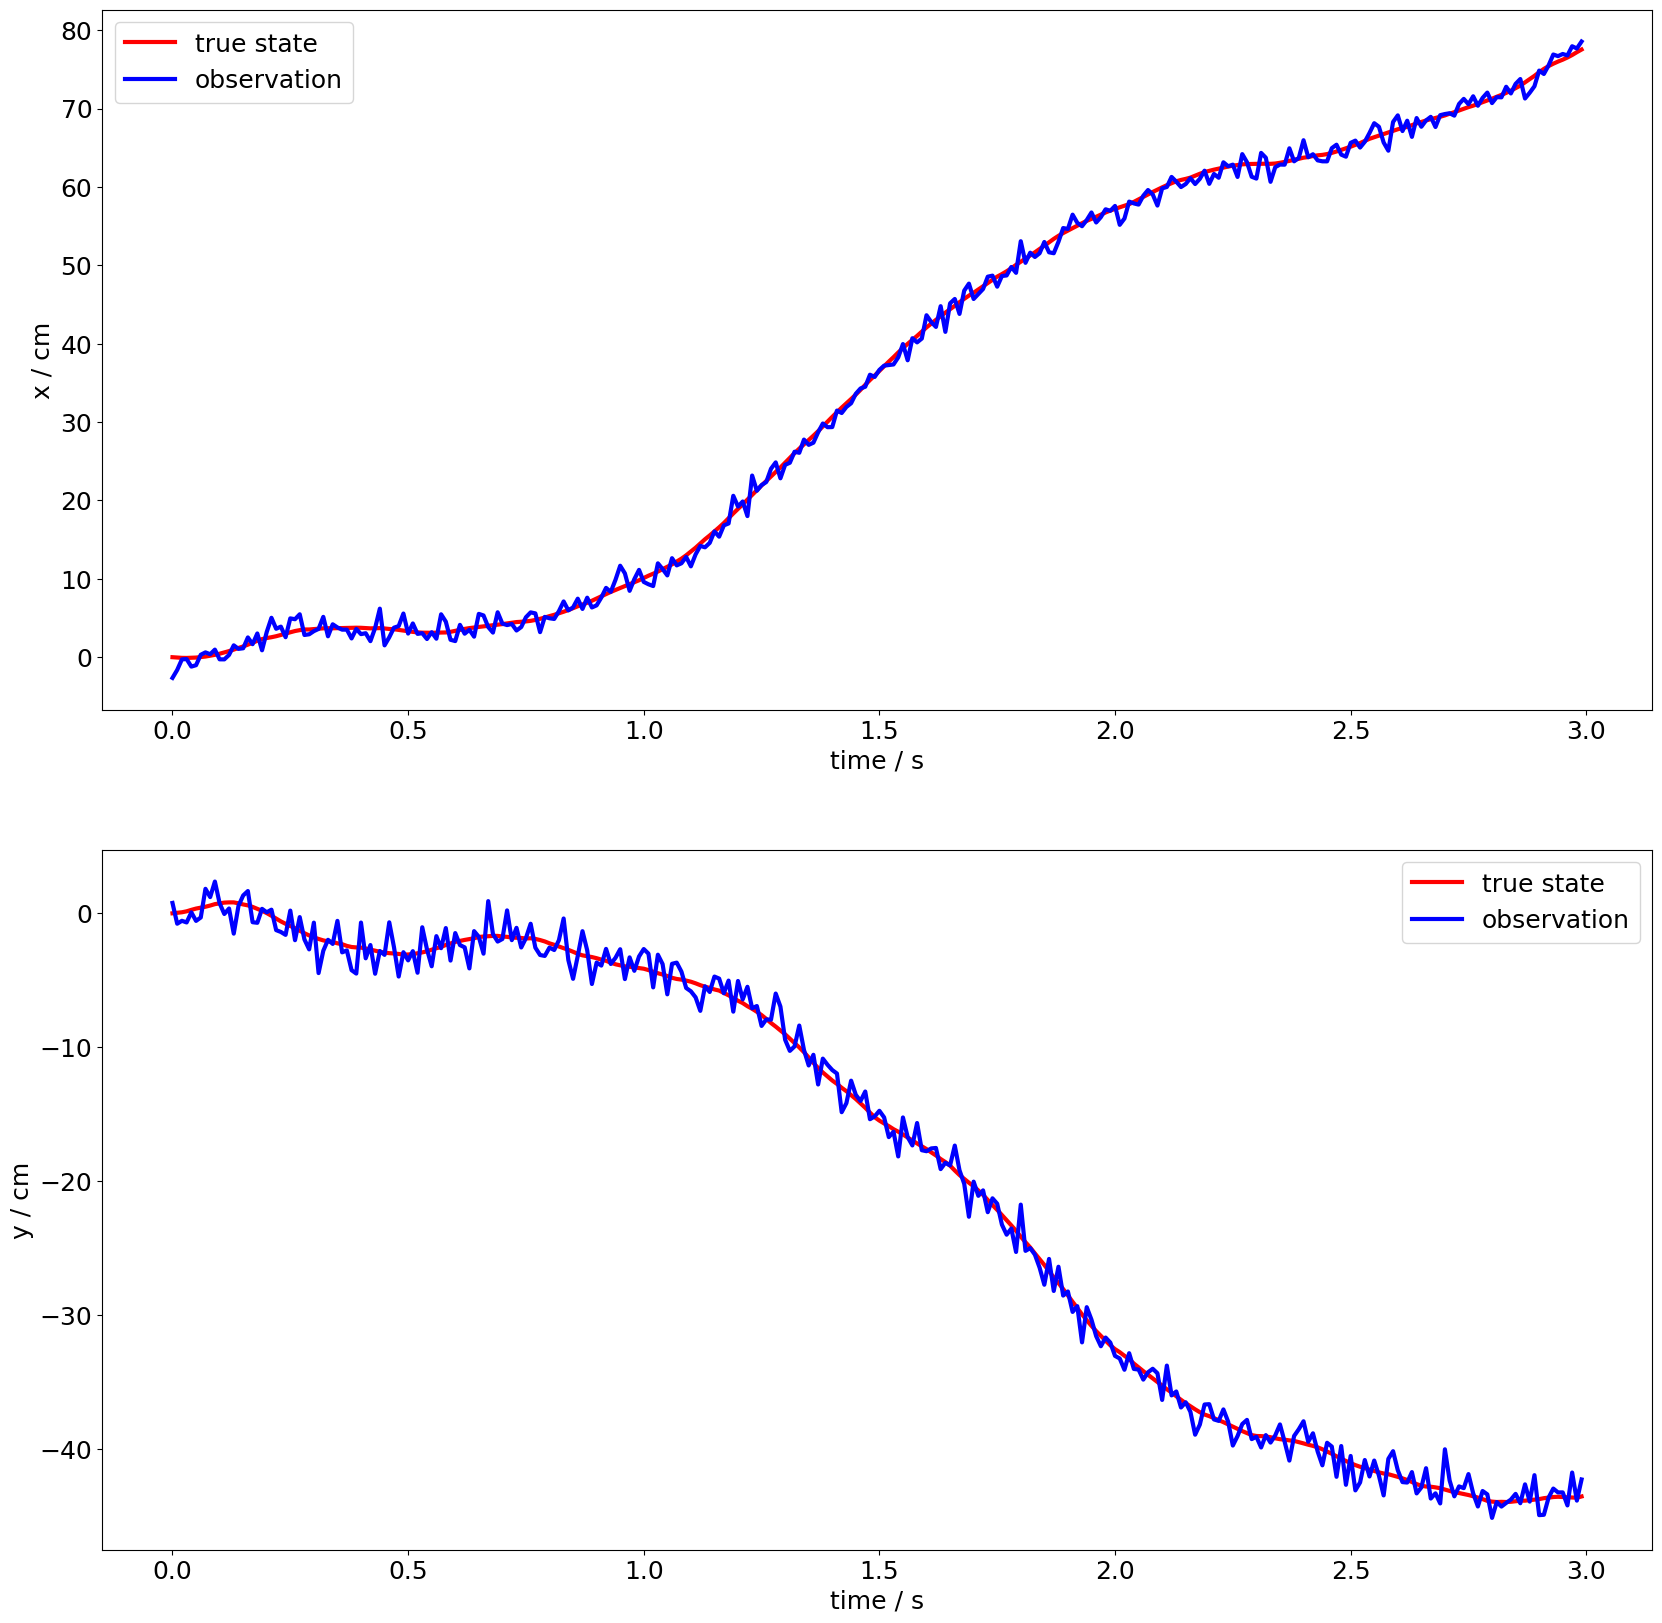

In [16]:
# Display coordinate-wise observations over time
_, ax = plt.subplots(2, 1, figsize=(20, 20))
ax[0].plot(total_steps*T, true_position_history[:, 0], 'r', linewidth=3, label='true state')
ax[0].plot(total_steps*T, observation_history[:, 0], 'b', linewidth=3, label='observation')
ax[0].set_xlabel('time / s')
ax[0].set_ylabel('x / cm')
ax[0].legend()
ax[1].plot(total_steps*T, true_position_history[:, 1], 'r', linewidth=3, label='true state')
ax[1].plot(total_steps*T, observation_history[:, 1], 'b', linewidth=3, label='observation')
ax[1].set_xlabel('time / s')
ax[1].set_ylabel('y / cm')
ax[1].legend()
plt.show()

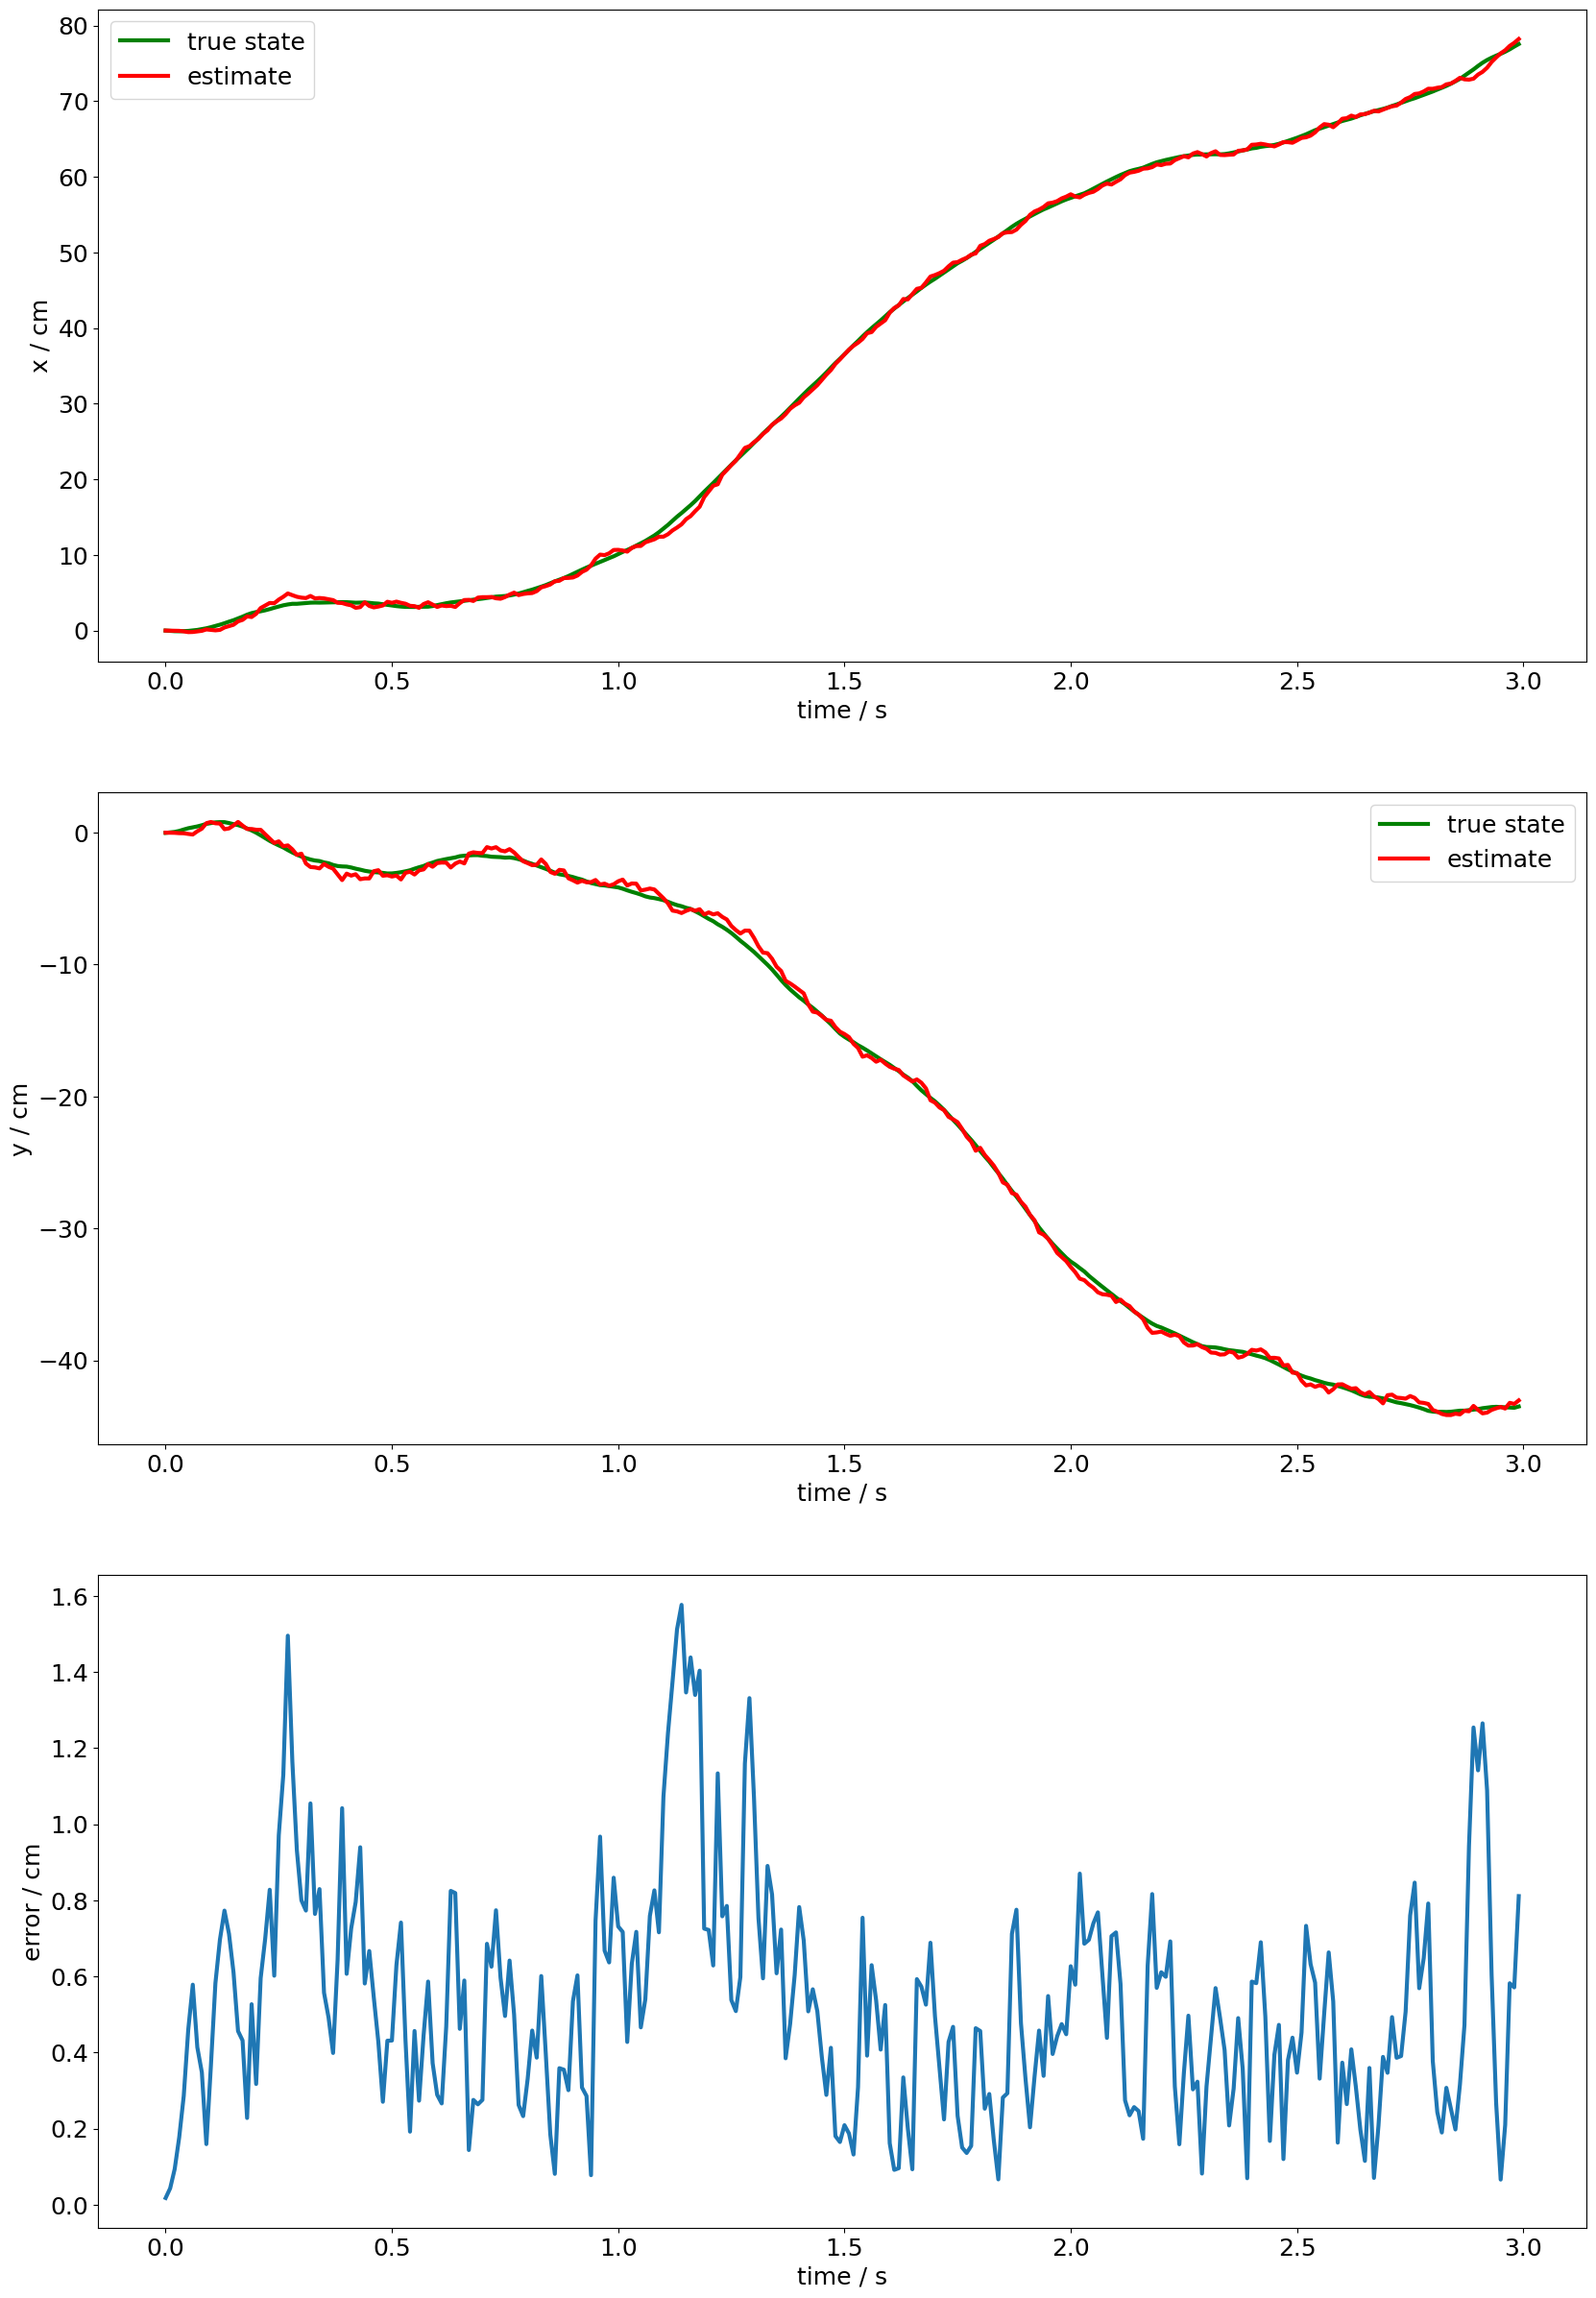

In [17]:
# Display coordinate-wise position over time
_, ax = plt.subplots(3, 1, figsize=(20, 30))
ax[0].plot(total_steps*T, true_position_history[:, 0], 'g', linewidth=3, label='true state')
ax[0].plot(total_steps*T, position_estimate_history[:, 0], 'r', linewidth=3, label='estimate')
ax[0].set_xlabel('time / s')
ax[0].set_ylabel('x / cm')
ax[0].legend()
ax[1].plot(total_steps*T, true_position_history[:, 1], 'g', linewidth=3, label='true state')
ax[1].plot(total_steps*T, position_estimate_history[:, 1], 'r', linewidth=3, label='estimate')
ax[1].set_xlabel('time / s')
ax[1].set_ylabel('y / cm')
ax[1].legend()
ax[2].plot(total_steps*T, estimation_error, linewidth=3)
ax[2].set_xlabel('time / s')
ax[2].set_ylabel('error / cm')
plt.show()


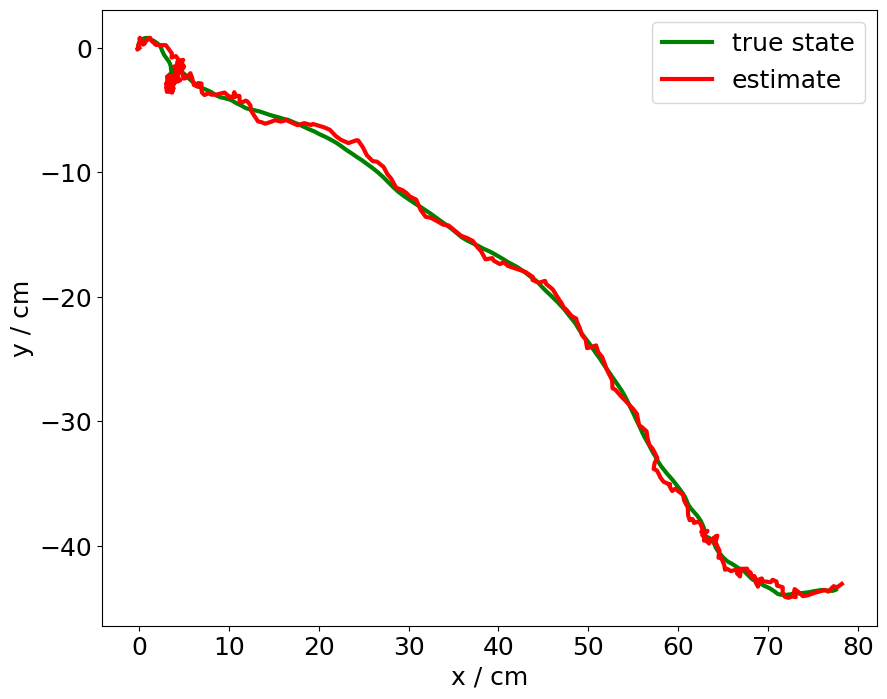

In [18]:
# Display trajectories
plt.figure(figsize=(10,8))
plt.plot(true_position_history[:, 0], true_position_history[: , 1], 'g', linewidth=3, label='true state')
plt.plot(position_estimate_history[:, 0], position_estimate_history[:, 1], 'r', linewidth=3, label='estimate')
plt.xlabel('x / cm')
plt.ylabel('y / cm')
plt.legend()
plt.show()